# 阶段4：模型评估与报告

本notebook完成以下任务：
1. 加载最佳模型和测试集数据
2. 在测试集上进行最终评估
3. 混淆矩阵分析
4. 分组性能分析
5. 时间序列预测可视化
6. SHAP值分析（可解释性）
7. 生成完整评估报告


In [1]:
# 导入必要的库和配置
%run 00_config_and_setup.ipynb

import config
from utils.data_utils import load_intermediate, save_intermediate
from utils.model_utils import evaluate_model, save_model_report

import tensorflow as tf
from tensorflow import keras
import shap
import seaborn as sns

print("准备开始最终评估...")


✓ 所有库导入完成
✓ 配置文件加载完成
项目根目录: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025
输出目录: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs
中间结果目录: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate
✓ 显示选项设置完成
✓ 输出目录创建完成
  - 中间结果: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate
  - 模型文件: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\models
  - 报告文件: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\reports
  - 可视化: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\visualizations
✓ 随机种子设置为: 42
✓ 可视化样式设置完成: seaborn-v0_8
✓ 工具函数导入完成
准备开始最终评估...


## 1. 加载模型和数据


In [2]:
# 加载测试集序列和最佳模型信息
X_test_seq = load_intermediate('X_test_seq') if 'X_test_seq' in str(config.INTERMEDIATE_DIR) else None
Y_test_seq = load_intermediate('Y_test_seq') if 'Y_test_seq' in str(config.INTERMEDIATE_DIR) else None
test_groups = load_intermediate('test_groups') if 'test_groups' in str(config.INTERMEDIATE_DIR) else None

# 如果序列未保存，重新创建
if X_test_seq is None:
    from utils.model_utils import create_sequences_by_group
    test_data = load_intermediate('test_data')
    y_test = load_intermediate('y_test')
    top_m_features = load_intermediate('top_m_features')
    X_test_seq, Y_test_seq, test_groups = create_sequences_by_group(
        test_data, y_test,
        selected_features=top_m_features,
        sequence_length=config.SEQUENCE_CONFIG['sequence_length']
    )

# 加载最佳模型
best_model_name = load_intermediate('best_model_name')
best_model_path = config.MODELS_DIR / f'{best_model_name.lower()}_best.h5'
best_model = keras.models.load_model(best_model_path)

print(f"最佳模型: {best_model_name}")
print(f"测试集序列形状: {X_test_seq.shape}")
print(f"测试集标签形状: {Y_test_seq.shape}")


已加载: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\test_data.pkl
已加载: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\y_test.pkl
已加载: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\top_m_features.pkl


已加载: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\best_model_name.pkl
最佳模型: GRU
测试集序列形状: (89901, 10, 30)
测试集标签形状: (89901,)


## 2. 测试集评估


In [3]:
# 在测试集上预测
print("在测试集上预测...")
y_pred_proba = best_model.predict(X_test_seq, verbose=0)
is_binary = y_pred_proba.shape[1] == 1 if len(y_pred_proba.shape) > 1 else True

if is_binary:
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
else:
    y_pred = np.argmax(y_pred_proba, axis=1)

# 评估性能
test_metrics = evaluate_model(
    Y_test_seq, 
    y_pred, 
    y_pred_proba.flatten() if is_binary else y_pred_proba,
    binary=is_binary
)

print("\n=== 测试集性能 ===")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1 Score: {test_metrics['f1_score']:.4f}")
if 'auc_roc' in test_metrics:
    print(f"AUC-ROC: {test_metrics['auc_roc']:.4f}")
if 'average_precision' in test_metrics:
    print(f"Average Precision: {test_metrics['average_precision']:.4f}")

# 保存结果
save_intermediate('test_metrics', test_metrics)
save_intermediate('test_predictions', {'y_pred': y_pred, 'y_pred_proba': y_pred_proba})


在测试集上预测...

=== 测试集性能 ===
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
AUC-ROC: nan
Average Precision: 1.0000
已保存: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\test_metrics.pkl
已保存: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\test_predictions.pkl


d:\Anaconda\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


## 3. 混淆矩阵可视化


d:\Anaconda\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from font(s) Arial.
  fig.canvas.draw()
d:\Anaconda\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 38656 (\N{CJK UNIFIED IDEOGRAPH-9700}) missing from font(s) Arial.
  fig.canvas.draw()
d:\Anaconda\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) Arial.
  fig.canvas.draw()
d:\Anaconda\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 24178 (\N{CJK UNIFIED IDEOGRAPH-5E72}) missing from font(s) Arial.
  fig.canvas.draw()
d:\Anaconda\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) Arial.
  fig.canvas.draw()
C:\Users\nowan\AppData\Local\Temp\ipykernel_22096\1409046003.py:10: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipyker

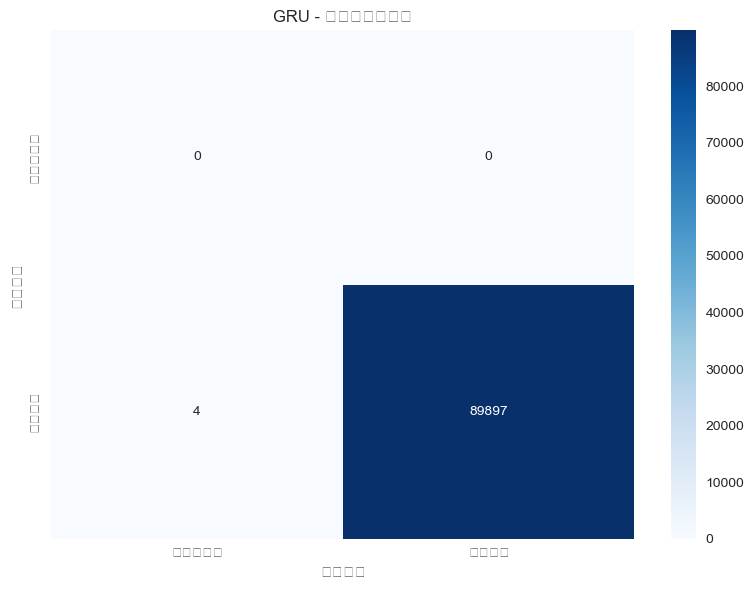

In [4]:
# 绘制混淆矩阵
cm = test_metrics['confusion_matrix']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['不需要干预', '需要干预'],
            yticklabels=['不需要干预', '需要干预'])
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.title(f'{best_model_name} - 测试集混淆矩阵')
plt.tight_layout()
plt.savefig(config.VISUALIZATIONS_DIR / 'test_confusion_matrix.png', dpi=config.PLOT_DPI, bbox_inches='tight')
plt.show()


## 4. 分组性能分析


d:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(



组11:
  样本数: 89220
  Accuracy: 1.0000
  F1 Score: 1.0000

组12:
  样本数: 681
  Accuracy: 0.9941
  F1 Score: 0.9971


C:\Users\nowan\AppData\Local\Temp\ipykernel_22096\3501537302.py:27: UserWarning: Glyph 32452 (\N{CJK UNIFIED IDEOGRAPH-7EC4}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_22096\3501537302.py:27: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_22096\3501537302.py:27: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_22096\3501537302.py:27: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_22096\3501537302.py:27: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_22096\3501537302.py:28: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404})

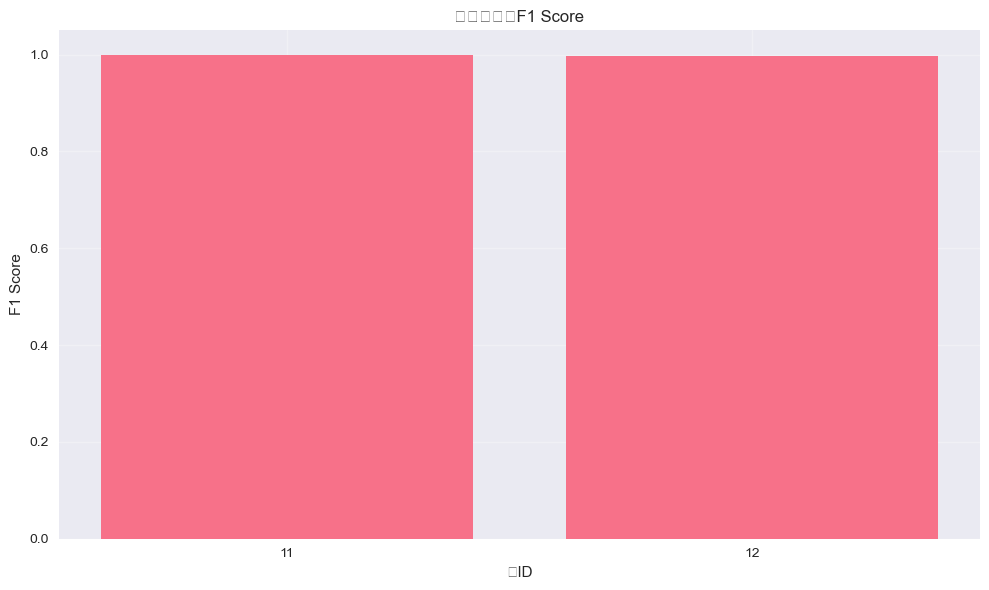

已保存: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\group_metrics.pkl


In [5]:
# 按组分析性能
group_metrics = {}
unique_groups = np.unique(test_groups)

for group_id in unique_groups:
    group_mask = test_groups == group_id
    y_true_group = Y_test_seq[group_mask]
    y_pred_group = y_pred[group_mask]
    
    metrics = evaluate_model(y_true_group, y_pred_group, binary=is_binary)
    group_metrics[group_id] = metrics
    
    print(f"\n组{group_id}:")
    print(f"  样本数: {len(y_true_group)}")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  F1 Score: {metrics['f1_score']:.4f}")

# 可视化分组性能
group_f1 = [group_metrics[g]['f1_score'] for g in unique_groups]
plt.figure(figsize=(10, 6))
plt.bar(range(len(unique_groups)), group_f1)
plt.xlabel('组ID')
plt.ylabel('F1 Score')
plt.title('各测试组的F1 Score')
plt.xticks(range(len(unique_groups)), unique_groups)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(config.VISUALIZATIONS_DIR / 'group_performance.png', dpi=config.PLOT_DPI, bbox_inches='tight')
plt.show()

# 保存分组结果
save_intermediate('group_metrics', group_metrics)


## 5. 时间序列预测可视化（示例组）


C:\Users\nowan\AppData\Local\Temp\ipykernel_22096\543999780.py:28: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_22096\543999780.py:28: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_22096\543999780.py:28: UserWarning: Glyph 31383 (\N{CJK UNIFIED IDEOGRAPH-7A97}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_22096\543999780.py:28: UserWarning: Glyph 21475 (\N{CJK UNIFIED IDEOGRAPH-53E3}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_22096\543999780.py:28: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_22096\543999780.py:28: UserWarning: Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missi

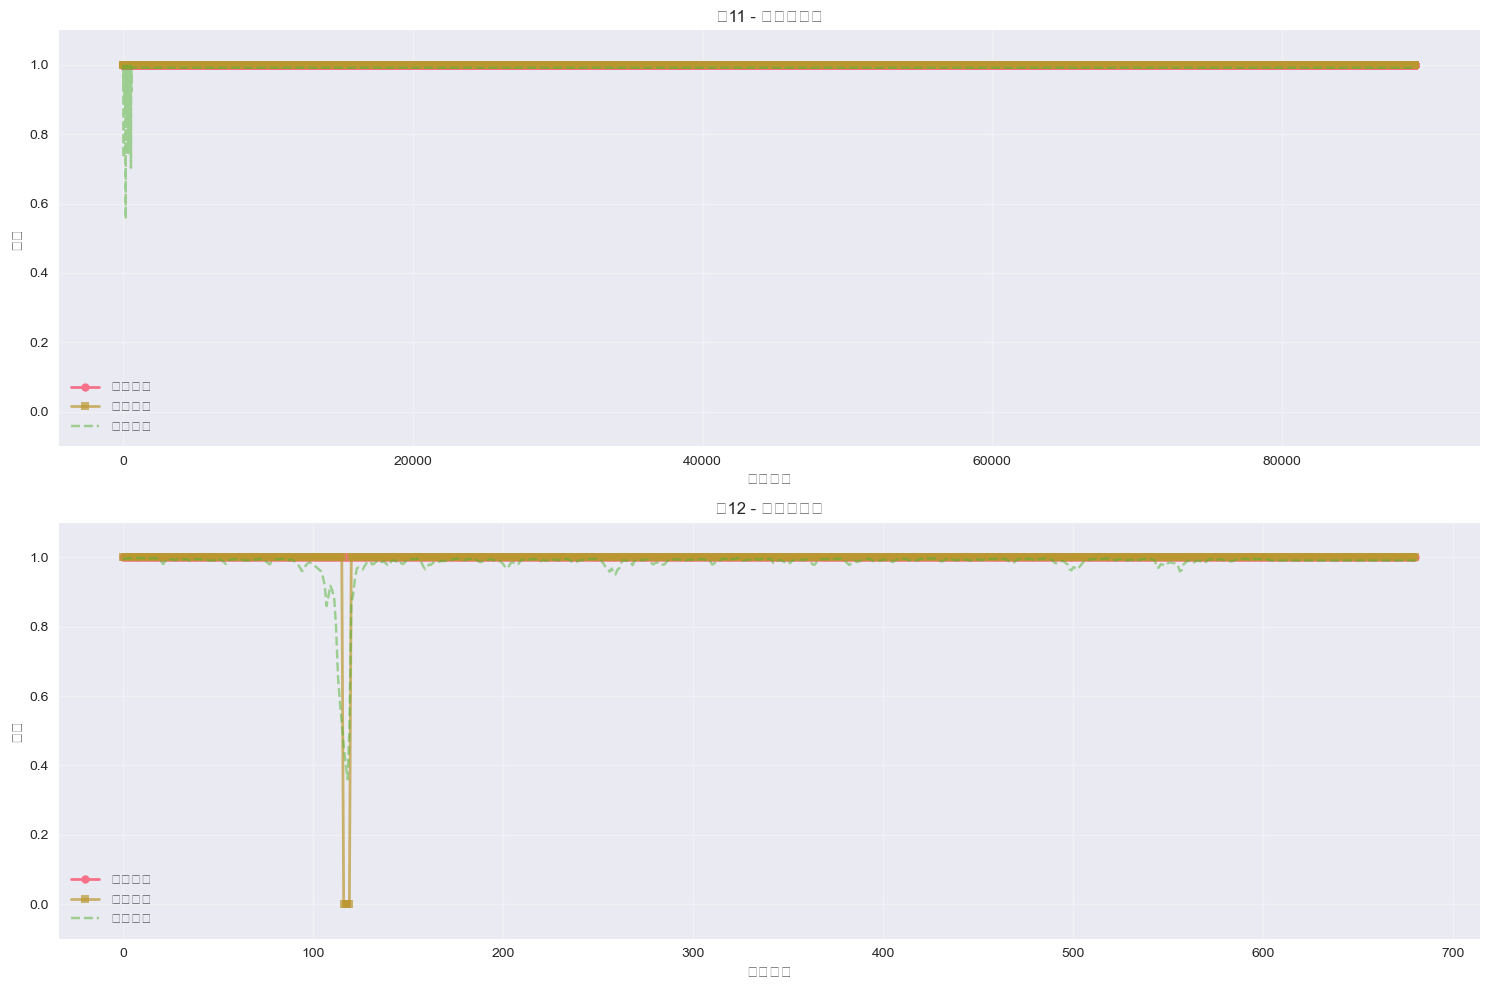

In [6]:
# 选择几个示例组进行可视化
example_groups = unique_groups[:min(3, len(unique_groups))]

fig, axes = plt.subplots(len(example_groups), 1, figsize=(15, 5*len(example_groups)))
if len(example_groups) == 1:
    axes = [axes]

for idx, group_id in enumerate(example_groups):
    group_mask = test_groups == group_id
    y_true_group = Y_test_seq[group_mask]
    y_pred_group = y_pred[group_mask]
    y_pred_proba_group = y_pred_proba[group_mask].flatten() if is_binary else y_pred_proba[group_mask]
    
    x_axis = np.arange(len(y_true_group))
    
    axes[idx].plot(x_axis, y_true_group, 'o-', label='真实标签', linewidth=2, markersize=6)
    axes[idx].plot(x_axis, y_pred_group, 's-', label='预测标签', linewidth=2, markersize=6, alpha=0.7)
    if is_binary:
        axes[idx].plot(x_axis, y_pred_proba_group, '--', label='预测概率', alpha=0.5)
    
    axes[idx].set_xlabel('时间窗口')
    axes[idx].set_ylabel('标签')
    axes[idx].set_title(f'组{group_id} - 预测时间线')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.savefig(config.VISUALIZATIONS_DIR / 'prediction_timelines.png', dpi=config.PLOT_DPI, bbox_inches='tight')
plt.show()


## 6. SHAP值分析（可解释性，可选）


In [7]:
# 使用SHAP分析特征重要性（使用较小的样本集）
print("计算SHAP值...")
sample_size = min(50, len(X_test_seq))
sample_indices = np.random.choice(len(X_test_seq), sample_size, replace=False)
X_sample = X_test_seq[sample_indices]

# 对于神经网络，使用DeepExplainer或KernelExplainer
try:
    # 尝试使用DeepExplainer（适用于神经网络）
    explainer = shap.DeepExplainer(best_model, X_sample[:10])  # 使用更小的背景集
    shap_values = explainer.shap_values(X_sample)
    
    # 对于二分类，取正类的SHAP值
    if isinstance(shap_values, list):
        shap_values = shap_values[1] if len(shap_values) > 1 else shap_values[0]
    
    # 可视化
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_sample, feature_names=load_intermediate('top_m_features'), show=False)
    plt.tight_layout()
    plt.savefig(config.VISUALIZATIONS_DIR / 'shap_summary.png', dpi=config.PLOT_DPI, bbox_inches='tight')
    plt.show()
    
    print("✓ SHAP分析完成")
except Exception as e:
    print(f"SHAP分析失败: {e}")
    print("跳过SHAP分析")


计算SHAP值...


d:\Anaconda\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
d:\Anaconda\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_1
Received: inputs=['Tensor(shape=(10, 10, 30))']
  warnings.warn(msg)
d:\Anaconda\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_1
Received: inputs=['Tensor(shape=(20, 10, 30))']
  warnings.warn(msg)


SHAP分析失败: in user code:

    File "d:\Anaconda\Lib\site-packages\shap\explainers\_deep\deep_tf.py", line 265, in grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)

    LookupError: gradient registry has no entry for: shap_TensorListStack

跳过SHAP分析


## 7. 生成完整评估报告


In [8]:
# 生成最终评估报告
report_path = config.REPORTS_DIR / 'final_evaluation_report.txt'

# 加载验证集结果进行对比
val_results = load_intermediate('val_results')

with open(report_path, 'w', encoding='utf-8') as f:
    f.write("=== 最终评估报告 ===\n\n")
    
    f.write("1. 模型信息\n")
    f.write(f"   最佳模型: {best_model_name}\n")
    f.write(f"   模型路径: {best_model_path}\n")
    
    f.write("\n2. 验证集性能（模型选择）\n")
    for model_name, metrics in val_results.items():
        f.write(f"   {model_name}:\n")
        f.write(f"     Accuracy: {metrics['accuracy']:.4f}\n")
        f.write(f"     F1 Score: {metrics['f1_score']:.4f}\n")
        if 'auc_roc' in metrics:
            f.write(f"     AUC-ROC: {metrics['auc_roc']:.4f}\n")
    
    f.write("\n3. 测试集性能（最终评估）\n")
    f.write(f"   Accuracy: {test_metrics['accuracy']:.4f}\n")
    f.write(f"   Precision: {test_metrics['precision']:.4f}\n")
    f.write(f"   Recall: {test_metrics['recall']:.4f}\n")
    f.write(f"   F1 Score: {test_metrics['f1_score']:.4f}\n")
    if 'auc_roc' in test_metrics:
        f.write(f"   AUC-ROC: {test_metrics['auc_roc']:.4f}\n")
    if 'average_precision' in test_metrics:
        f.write(f"   Average Precision: {test_metrics['average_precision']:.4f}\n")
    
    f.write("\n4. 混淆矩阵\n")
    f.write(f"   {test_metrics['confusion_matrix'].tolist()}\n")
    
    f.write("\n5. 分组性能\n")
    for group_id in sorted(unique_groups):
        metrics = group_metrics[group_id]
        f.write(f"   组{group_id}: F1={metrics['f1_score']:.4f}, Accuracy={metrics['accuracy']:.4f}\n")
    
    f.write("\n6. 数据统计\n")
    f.write(f"   测试集样本数: {len(Y_test_seq)}\n")
    f.write(f"   测试集标签分布: {pd.Series(Y_test_seq).value_counts().to_dict()}\n")
    f.write(f"   测试组数: {len(unique_groups)}\n")

print(f"已生成最终评估报告: {report_path}")

# 同时保存模型性能报告
save_model_report(test_metrics, f'{best_model_name}_test', 
                 config.REPORTS_DIR / f'{best_model_name}_test_performance.txt')


已加载: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\val_results.pkl
已生成最终评估报告: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\reports\final_evaluation_report.txt
已保存报告: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\reports\GRU_test_performance.txt
